# IMPORT LIBRARIES & DATA


In [1]:

import sys
sys.path.append('../src')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from GA import solve

import tracemalloc

import random


In [2]:
distance_df = pd.read_csv('../data/HN_distance_matrix.csv', index_col=0)
distance_matrix = distance_df.values

# Kiểm tra sơ bộ
print("Số thành phố:", distance_matrix.shape[0])
print("Ví dụ khoảng cách [0][1]:", distance_matrix[0][1])


Số thành phố: 127
Ví dụ khoảng cách [0][1]: 21.48


In [3]:
def detect_convergence(generation_fitness, tolerance=1e-3, window=5):
    for i in range(len(generation_fitness) - window):
        window_values = generation_fitness[i:i+window]
        if max(window_values) - min(window_values) < tolerance:
            return i + window
    return len(generation_fitness)

# GA + Local search


========== Số người (m) = 1 | Chạy 20 lần ==========


100%|█████████████████████████████████████████| 300/300 [02:16<00:00,  2.19it/s]



   [Hoàn thành 20 lần chạy cho m=1]
   => Trung bình Dist: 761.11 (±106.31)
   => Trung bình Time: 140.2748s
   => Trung bình Balance: 0.00


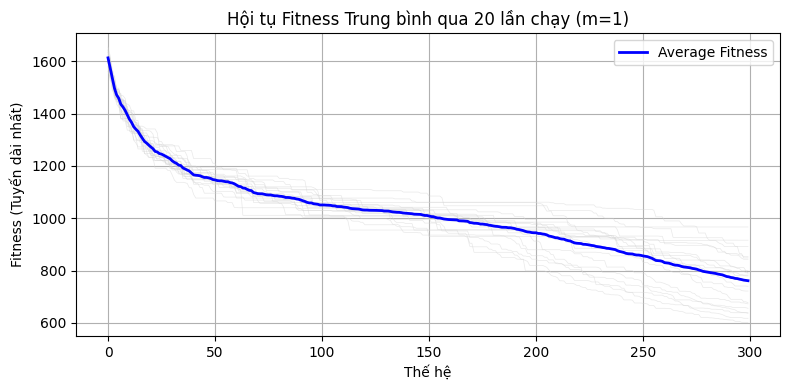


========== Số người (m) = 2 | Chạy 20 lần ==========


100%|█████████████████████████████████████████| 300/300 [02:54<00:00,  1.72it/s]



   [Hoàn thành 20 lần chạy cho m=2]
   => Trung bình Dist: 1116.27 (±53.63)
   => Trung bình Time: 150.3025s
   => Trung bình Balance: 3.39


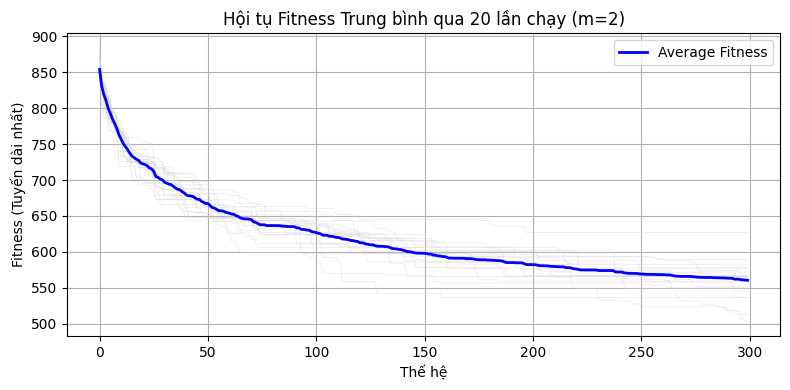


========== Số người (m) = 3 | Chạy 20 lần ==========


100%|█████████████████████████████████████████| 300/300 [02:36<00:00,  1.92it/s]



   [Hoàn thành 20 lần chạy cho m=3]
   => Trung bình Dist: 1286.29 (±34.40)
   => Trung bình Time: 199.0849s
   => Trung bình Balance: 7.16


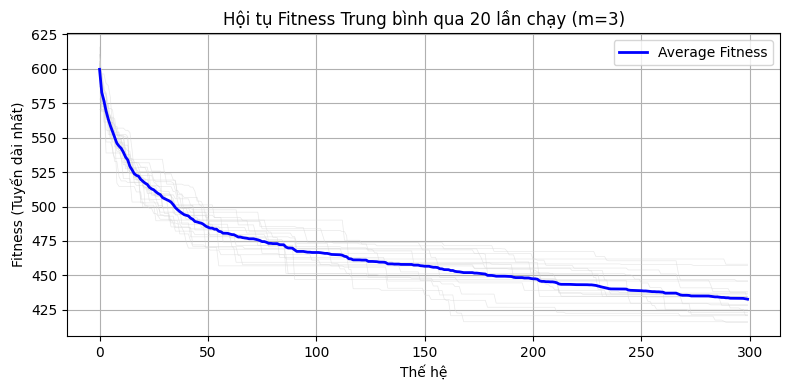


=== HOÀN TẤT TOÀN BỘ QUÁ TRÌNH ===


In [ ]:

# --- CẤU HÌNH ---
N_TRIALS = 20  # Số lần chạy mỗi kịch bản (20 lần)
m_values = range(1, 4)  # Số người từ 1 đến 3

# Tên file lưu trữ
detail_file = "results_details_20runs.csv"   # Lưu từng lần chạy
stats_file = "results_stats_summary.csv"     # Lưu trung bình & độ lệch chuẩn

# Cột dữ liệu cần theo dõi
metrics = [
    "total_distance", "fitness", "balance_metric", 
    "exec_time", "memory_current_MB", "memory_peak_MB", 
    "converged_gen", "convergence_speed"
]

# Tạo file rỗng ban đầu với header
pd.DataFrame(columns=["m", "trial"] + metrics).to_csv(detail_file, index=False)

stats_cols = ["m"] + [f"{col}_mean" for col in metrics] + [f"{col}_std" for col in metrics]
pd.DataFrame(columns=stats_cols).to_csv(stats_file, index=False)

# --- VÒNG LẶP CHÍNH ---
for m in m_values:
    print(f"\n{'='*10} Số người (m) = {m} | Chạy {N_TRIALS} lần {'='*10}")
    
    # List lưu kết quả của 20 lần chạy cho m hiện tại
    trial_results = []
    
    # List lưu lịch sử fitness để vẽ biểu đồ trung bình
    all_fitness_history = [] 

    for trial in range(1, N_TRIALS + 1):
        # 1. Đo tài nguyên & Thời gian
        tracemalloc.start()
        start_time = time.time()
        
        # 2. Chạy thuật toán
        # Lưu ý: Hàm solve cần trả về fitness_per_generation (list các giá trị fitness qua từng gen)
        total_distance, routes, fitness, fitness_per_generation = solve(distance_matrix, m)
        
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        exec_time = end_time - start_time

        # 3. Tính toán các chỉ số
        route_distances = [
            sum(distance_matrix[r[i]][r[i+1]] for i in range(len(r)-1))
            for r in routes
        ]
        balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

        converged_gen = detect_convergence(fitness_per_generation)
        convergence_speed = (fitness_per_generation[0] - fitness_per_generation[-1]) / converged_gen if converged_gen else 0

        # 4. Lưu kết quả chi tiết của lần chạy này
        row = {
            "m": m,
            "trial": trial,
            "total_distance": total_distance,
            "fitness": fitness,
            "balance_metric": balance_metric,
            "exec_time": exec_time,
            "memory_current_MB": current / 10**6,
            "memory_peak_MB": peak / 10**6,
            "converged_gen": converged_gen,
            "convergence_speed": convergence_speed
        }
        trial_results.append(row)
        all_fitness_history.append(fitness_per_generation)

        # Ghi ngay vào file detail (append mode) để tránh mất dữ liệu nếu crash
        pd.DataFrame([row]).to_csv(detail_file, mode="a", index=False, header=False)
        
        # In tiến độ gọn gàng (Overwrite dòng cũ)
        
    print(f"\n   [Hoàn thành {N_TRIALS} lần chạy cho m={m}]")

    # --- TÍNH TOÁN THỐNG KÊ (MEAN & STD) ---
    df_trials = pd.DataFrame(trial_results)
    
    stats_row = {"m": m}
    for col in metrics:
        stats_row[f"{col}_mean"] = df_trials[col].mean()
        stats_row[f"{col}_std"] = df_trials[col].std() # Mặc định ddof=1 (mẫu)
    
    # Lưu vào file stats
    pd.DataFrame([stats_row]).to_csv(stats_file, mode="a", index=False, header=False)

    # In báo cáo nhanh ra màn hình
    print(f"   => Trung bình Dist: {stats_row['total_distance_mean']:.2f} (±{stats_row['total_distance_std']:.2f})")
    print(f"   => Trung bình Time: {stats_row['exec_time_mean']:.4f}s") 
    print(f"   => Trung bình Balance: {stats_row['balance_metric_mean']:.2f}")

    # --- VẼ BIỂU ĐỒ FITNESS TRUNG BÌNH ---
    # Xử lý độ dài các lần chạy khác nhau (pad bằng giá trị cuối cùng để tính trung bình)
    max_len = max(len(h) for h in all_fitness_history)
    padded_history = []
    for h in all_fitness_history:
        # Nếu chạy ít hơn max_len, điền nốt bằng giá trị cuối cùng (đã hội tụ)
        padded = h + [h[-1]] * (max_len - len(h))
        padded_history.append(padded)
    
    avg_fitness_curve = np.mean(padded_history, axis=0)

    plt.figure(figsize=(8, 4))
    # Vẽ mờ các đường chạy lẻ
    for h in all_fitness_history:
        plt.plot(h, color='lightgray', alpha=0.5, linewidth=0.5)
    # Vẽ đường trung bình đậm
    plt.plot(avg_fitness_curve, color='blue', linewidth=2, label='Average Fitness')
    
    plt.title(f"Hội tụ Fitness Trung bình qua {N_TRIALS} lần chạy (m={m})")
    plt.xlabel("Thế hệ")
    plt.ylabel("Fitness (Tuyến dài nhất)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Hoặc plt.savefig(f"fitness_chart_m{m}_avg.png")

print("\n=== HOÀN TẤT TOÀN BỘ QUÁ TRÌNH ===")

In [ ]:

# File tổng hợp kết quả
summary_file = "results_summary_ga_combine.csv"
summary_cols = [
    "m", "total_distance", "fitness", "balance_metric", 
    "exec_time", "memory_current_MB", "memory_peak_MB", 
    "converged_gen", "convergence_speed"
]

# Tạo file rỗng (chỉ chạy lần đầu)
pd.DataFrame(columns=summary_cols).to_csv(summary_file, index=False)

for m in range(1, 4):
    print(f"\n=== Số người (m) = {m} ===")
    
    tracemalloc.start()
    start_time = time.time()
    
    total_distance, routes, fitness, fitness_per_generation = solve(distance_matrix, m)
    
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    exec_time = end_time - start_time

    # Độ dài từng tuyến
    route_distances = [
        sum(distance_matrix[r[i]][r[i+1]] for i in range(len(r)-1))
        for r in routes
    ]
    max_len = max(route_distances)
    min_len = min(route_distances)
    balance_metric = max_len - min_len

    # Phân tích hội tụ
    converged_gen = detect_convergence(fitness_per_generation)
    convergence_speed = (fitness_per_generation[0] - fitness_per_generation[-1]) / converged_gen if converged_gen else 0

    # In kết quả
    print(f"Tổng quãng đường: {total_distance:.2f}")
    print(f"Tuyến dài nhất (fitness): {fitness:.2f}")
    print(f"Chênh lệch giữa các tuyến (Balance metric): {balance_metric:.2f}")
    print(f"Thời gian thực thi: {exec_time:.4f} giây")
    print(f"Số vòng lặp để hội tụ: {converged_gen}")
    print(f"Tốc độ hội tụ: {convergence_speed:.4f} đơn vị/gen")
    print(f"Memory hiện tại: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")

    for i, r in enumerate(routes):
        print(f" - Tuyến {i+1} ({route_distances[i]:.2f}): {r}")

    # === Lưu file tổng hợp ===
    row = {
        "m": m,
        "total_distance": total_distance,
        "fitness": fitness,
        "balance_metric": balance_metric,
        "exec_time": exec_time,
        "memory_current_MB": current / 10**6,
        "memory_peak_MB": peak / 10**6,
        "converged_gen": converged_gen,
        "convergence_speed": convergence_speed
    }
    pd.DataFrame([row]).to_csv(summary_file, mode="a", index=False, header=False)

    # === Lưu fitness_per_generation riêng ===
    fitness_file = f"ga_combine_fitness_m{m}.csv"
    pd.DataFrame({"generation": range(len(fitness_per_generation)),
                  "fitness": fitness_per_generation}).to_csv(fitness_file, index=False)

    # Vẽ biểu đồ fitness (tùy chọn)
    plt.figure(figsize=(8, 4))
    plt.plot(fitness_per_generation, marker='o', linestyle='-', color='blue')
    plt.title(f"Fitness qua các thế hệ (m = {m})")
    plt.xlabel("Thế hệ")
    plt.ylabel("Fitness (Tuyến dài nhất)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# GASA


# RLGA

# NSGA II